In [1]:
import os
os.chdir('E:/tp2/data')

In [2]:
import time
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#word modeling
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA 
from sklearn.decomposition import FactorAnalysis 
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from gensim.parsing.preprocessing import remove_stopwords
import nltk

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore',message="Precision")

In [3]:
#load data
train_docs = pd.read_csv('train_corrected_with_stopwords_new.csv', names=['blog', 'class', "length"]).reset_index(drop=True)
valid_docs = [pd.read_csv('valid_corrected_with_stopwords/' + val, names=['blog', 'class', "length"]) for val in os.listdir("valid_corrected_with_stopwords")]


In [4]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
    return tokens

In [5]:
# Not sure if doc2vec represents well length of initial string. could add the length column 
train_docs

,blog,class,length
0,long time i have be busy with work school rehe...,0,225
1,what to talk about well today be totally borin...,0,114
2,just some stuff which animal be your sex symbo...,0,234
3,i goat a job n.w.t. yesterday i start work at ...,0,129
4,movie night i really do hate friday because i ...,0,146
...,...,...,...
512622,yes a. this be the end a. the end of life trap...,1,106
512623,here go seem like im the last one alive to hav...,1,136
512624,whenever i hear my band warm down i love it a....,1,502
512625,well since the last entry me and my girl talk ...,1,395


In [6]:
#The Doc2Vec model takes 'tagged_documents'
#tag the training data
t1 = time.time()
tagged_tr = [TaggedDocument(words=nltk.word_tokenize(remove_stopwords(str(_d).lower())), tags=[str(i)]) for i, _d in enumerate(train_docs.blog)]
t2 = time.time()    
print("Time: {}".format(t2-t1))

Time: 442.6077992916107


In [7]:
valid_doc_tagged = [[] for _ in range(len(valid_docs))]
for i, valid_doc in enumerate(valid_docs):
    print(i)
    valid_doc_tagged[i] = [TaggedDocument(words=nltk.word_tokenize(remove_stopwords(str(_d).lower())), tags=[str(i)]) for i, _d in enumerate(valid_doc.blog)]


0
1
2
3
4
5
6
7


In [28]:
#Instantiate the model
alpha=0.025
#build the vocab on the training data
vec_size = 20
window_size = 15
min_count = 2
sampling_threshold = 1e-5
negative_size = 5
train_epoch = 20

start_epoch=10

dm = 1 #0 = dbow; 1 = dmpv
worker_count = 8 #number of parallel processes
pretrained_emb = "enwiki_dbow" #None if use without pretrained embeddings
filename='5klects20_corrected_nostopwords_10.model'
if os.path.isfile(filename):
    print("Model found, loading...")
    model = Doc2Vec.load(filename)
    t1 = time.time()
    for epoch in range(start_epoch, train_epoch):
        print('iteration {0}'.format(epoch+1))
        model.train(tagged_tr,
                    total_examples=model.corpus_count,
                    epochs=model.epochs)
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

else:
    print("Model not found, training for", train_epoch, "...")
    t1 = time.time()
    model = Doc2Vec(size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=2,
                    dm =1)
    t2 = time.time()    
    #model = Doc2Vec(vector_size=100,  min_count=2,dm =1)
    print("Building vocabulary")
    model.build_vocab(tagged_tr)
    #max training epochs

    #train n epochs and save the model
    print("Model created in {}".format(t2-t1) )
    t1 = time.time()
    for epoch in range(train_epoch):
        print('iteration {0}'.format(epoch+1))
        model.train(tagged_tr,
                    total_examples=model.corpus_count,
                    epochs=model.epochs)
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha



print("done!")
t2 = time.time()    
model.save(filename)
print("Model Saved")
print("Time: {}".format(t2-t1))


Model found, loading...
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
done!
Model Saved
Time: 3916.5623841285706


In [37]:
filename='5klects20_corrected_nostopwords_20.model'
model.save(filename)

In [29]:
X_train = np.array([model.docvecs[str(i)] for i in range(len(tagged_tr))])
y_train = train_docs['class']

from imblearn.over_sampling import SVMSMOTE, SMOTE, BorderlineSMOTE, RandomOverSampler, KMeansSMOTE

# sm = SVMSMOTE(random_state=42, n_jobs=-1, svm_estimator=SVC(kernel='linear'))
sm = RandomOverSampler(random_state=42)
t1 = time.time()
X_res, y_res = sm.fit_resample(X_train, y_train)
t2 = time.time()        
print("Time for Reseampling: {}".format(t2-t1))
np.save('E:/tp2/data/train_posts_smote2_data', X_res)
np.save('E:/tp2/data/train_posts_smote2_targets', y_res)
df1 = pd.DataFrame(X_res)
df2 = pd.DataFrame(y_res, columns=["class"])
df = pd.concat([df1, df2], axis = 1).reset_index(drop=True) # seems like smote put them in order, need to shuffle

Time for Reseampling: 0.3291196823120117


In [30]:
X_train, y_train = df[df1.keys()], df["class"]
scaler = StandardScaler()
x = scaler.fit_transform(X_train)

In [31]:
X_valids = [[] for _ in range(len(valid_docs))]
for n, valid_doc in enumerate(valid_doc_tagged):
    print(n)
    X_valids[n] = np.array([model.infer_vector(valid.words) for valid in valid_doc])


0
1
2
3
4
5
6
7


In [32]:
X_valids = [scaler.transform(val) for i, val in enumerate(X_valids)]
y_valids = [valid['class'] for valid in valid_docs] 

<BarContainer object of 3 artists>

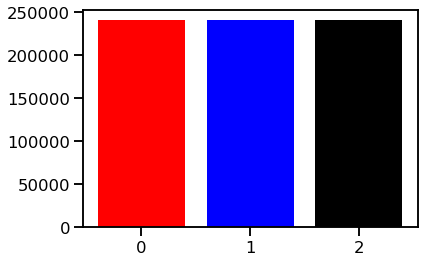

In [33]:
zeros = np.sum([1 if y==0 else 0 for y in y_train])
ones = np.sum([1 if y==1 else 0 for y in y_train])
twos = np.sum([1 if y==2 else 0 for y in y_train])

plt.bar([0, 1, 2], [zeros, ones, twos], color=['r', 'b', 'k'])

In [34]:
def heatconmat(y_true, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_train.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))



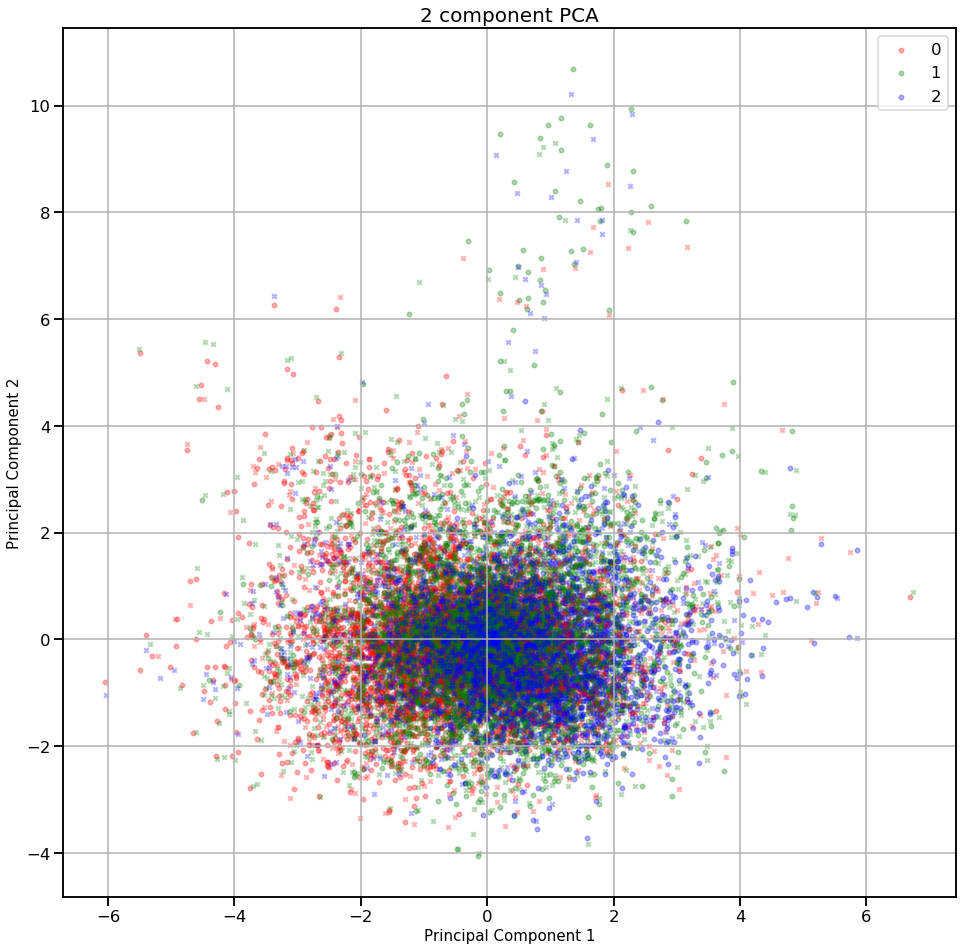

In [35]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf_pca = pd.concat([principalDf, y_train[:10000]], axis = 1).reset_index(drop=True)

principalComponents_valid = pca.fit_transform(x[:10000])
principalDf_valid = pd.DataFrame(data=principalComponents_valid, columns=['principal component 1', 'principal component 2'])
finalDf_pca_valid = pd.concat([principalDf_valid, y_valids[0][:10000]], axis = 1).reset_index(drop=True)


fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    ax.scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1']
               , finalDf_pca.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )


for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca_valid['class'] == target
    ax.scatter(finalDf_pca_valid.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca_valid.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 20, alpha=0.3, marker='x'
              )

ax.legend(targets)
ax.grid()

In [23]:
fig = plt.figure(figsize = (6, 6))
ax = sns.scatterplot(x='principal component 1', y='principal component 2', hue='class', data=finalDf_pca, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

Error in callback <function flush_figures at 0x000001A8323C40D0> (for post_execute):


KeyboardInterrupt: 

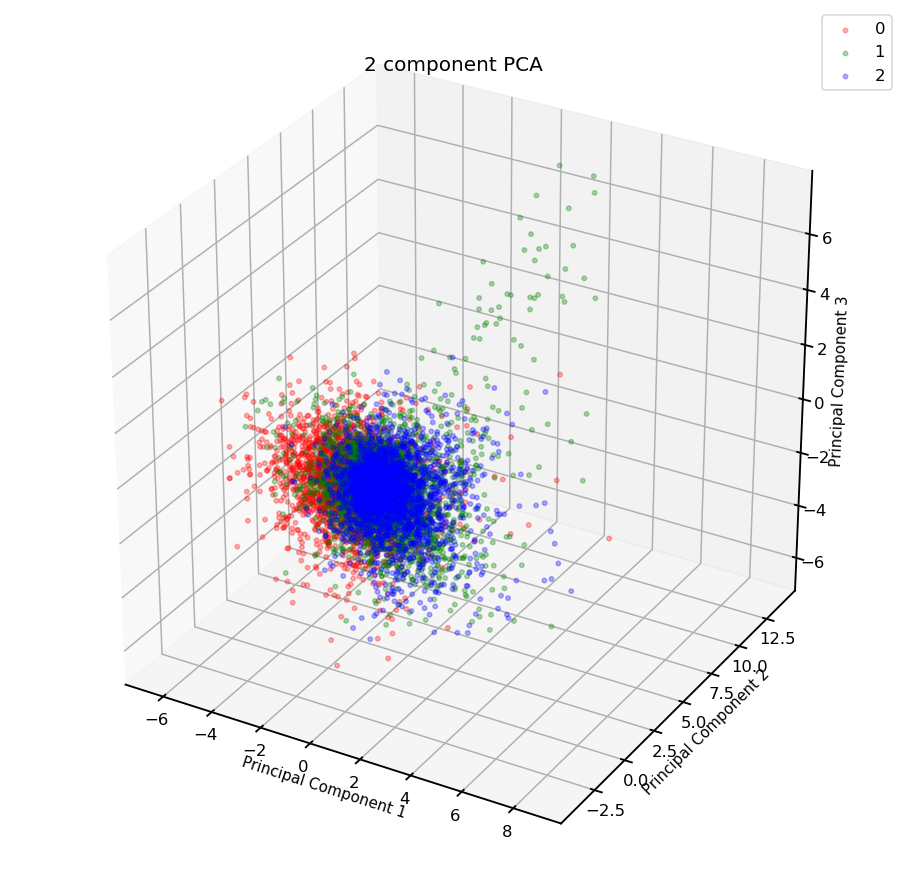

In [50]:
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2',  'principal component 3'])
finalDf_pca = pd.concat([principalDf, y_train[:10000]], axis = 1).reset_index(drop=True)
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    ax.scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 2'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

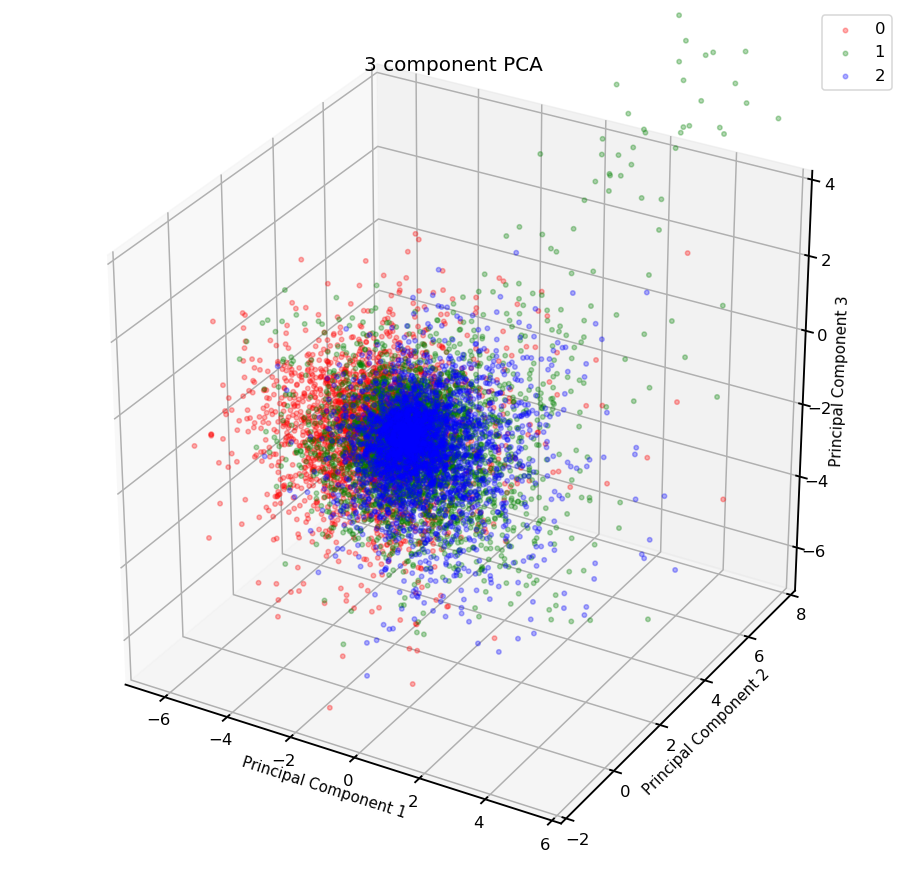

In [51]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    ax.scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 2'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
ax.set_xlim([-7, 6])
ax.set_ylim([-2, 8])
ax.set_zlim([-7, 4])

ax.legend(targets)
ax.grid()

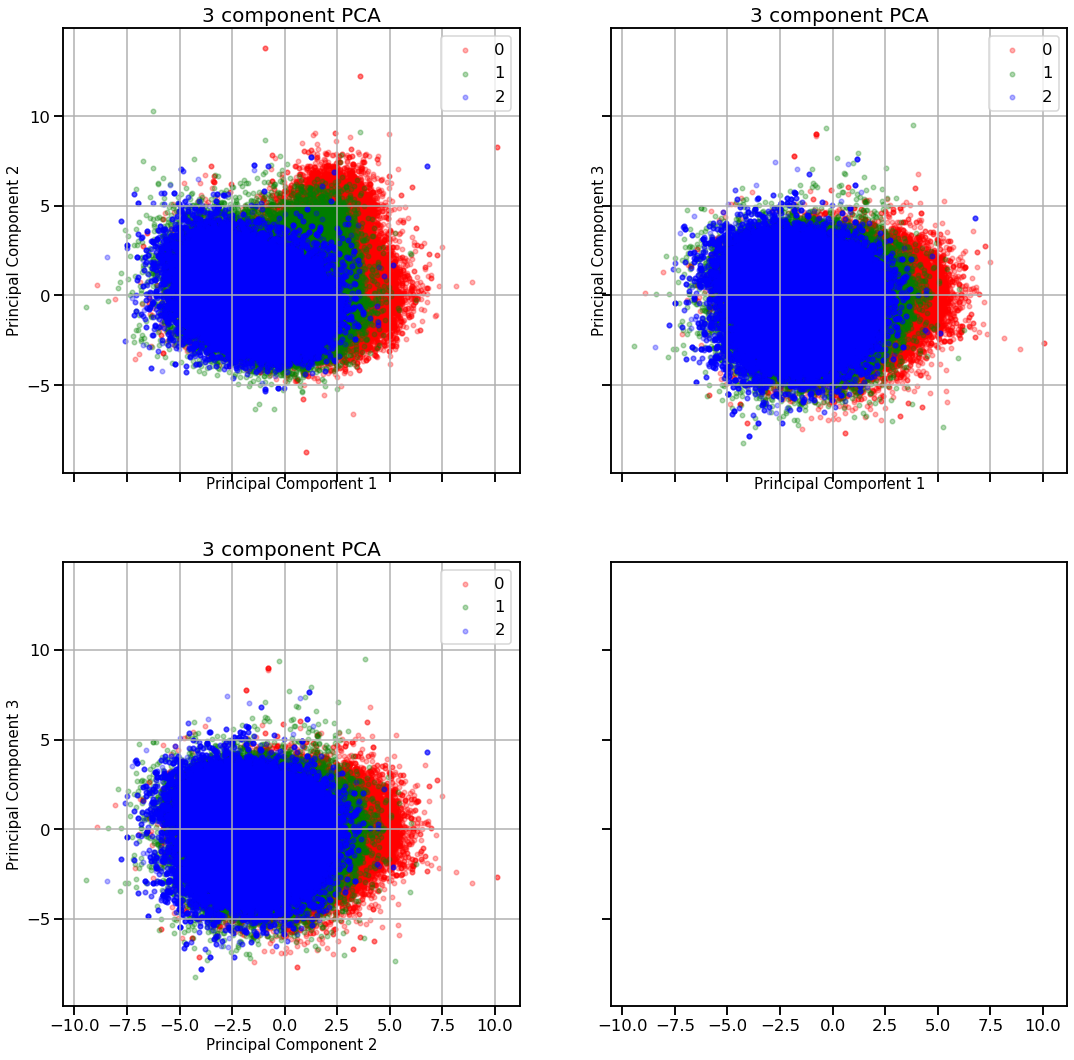

In [49]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True, figsize=(18, 18))
axs[0][0].set_xlabel('Principal Component 1', fontsize = 15)
axs[0][0].set_ylabel('Principal Component 2', fontsize = 15)
axs[0][0].set_title('3 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    axs[0][0].scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 2'],
               c = color,
               s = 20, alpha=0.3
              )
axs[0][0].legend(targets)
axs[0][0].grid()

axs[0][1].set_xlabel('Principal Component 1', fontsize = 15)
axs[0][1].set_ylabel('Principal Component 3', fontsize = 15)
axs[0][1].set_title('3 component PCA', fontsize = 20)
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    axs[0][1].scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
axs[0][1].legend(targets)
axs[0][1].grid()

axs[1][0].set_xlabel('Principal Component 2', fontsize = 15)
axs[1][0].set_ylabel('Principal Component 3', fontsize = 15)
axs[1][0].set_title('3 component PCA', fontsize = 20)
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_pca['class'] == target
    axs[1][0].scatter(finalDf_pca.loc[indicesToKeep, 'principal component 1'],
               finalDf_pca.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, alpha=0.3
              )
axs[1][0].legend(targets)
axs[1][0].grid()
plt.show()

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fLDA = LinearDiscriminantAnalysis(n_components=2)
y=y_train
principalComponents = fLDA.fit_transform(x, y)
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal component 1', 'Principal component 2'])
finalDf_fLDA = pd.concat([principalDf, y], axis = 1)

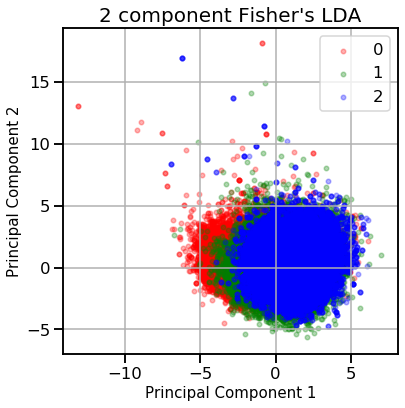

In [53]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component Fisher\'s LDA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_fLDA['class'] == target
    ax.scatter(finalDf_fLDA.loc[indicesToKeep, 'Principal component 1']
               , finalDf_fLDA.loc[indicesToKeep, 'Principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='Principal component 1', y='Principal component 2', hue='class', data=finalDf_fLDA, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='Principal component 1', y='Principal component 2', z='Principal component 3', hue='class', 
                     data=finalDf_fLDA, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

In [ ]:
fa = FactorAnalysis(n_components=2)
principalComponents = fa.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf_fa = pd.concat([principalDf, y_train], axis = 1)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_fa['class'] == target
    ax.scatter(finalDf_fa.loc[indicesToKeep, 'principal component 1']
               finalDf_fa.loc[indicesToKeep, 'principal component 2']
               c = color
               s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

In [52]:
tsne = TSNE(n_components=2, learning_rate=10000)
principalComponents = tsne.fit_transform(x[:10000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf_TSNE = pd.concat([principalDf, y_train], axis = 1)

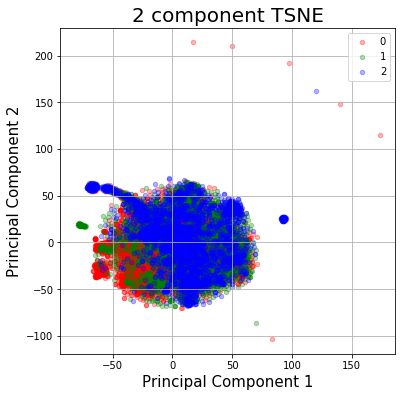

In [53]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE['class'] == target
    ax.scatter(finalDf_TSNE.loc[indicesToKeep, 'principal component 1']
               , finalDf_TSNE.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )
ax.legend(targets)
ax.grid()

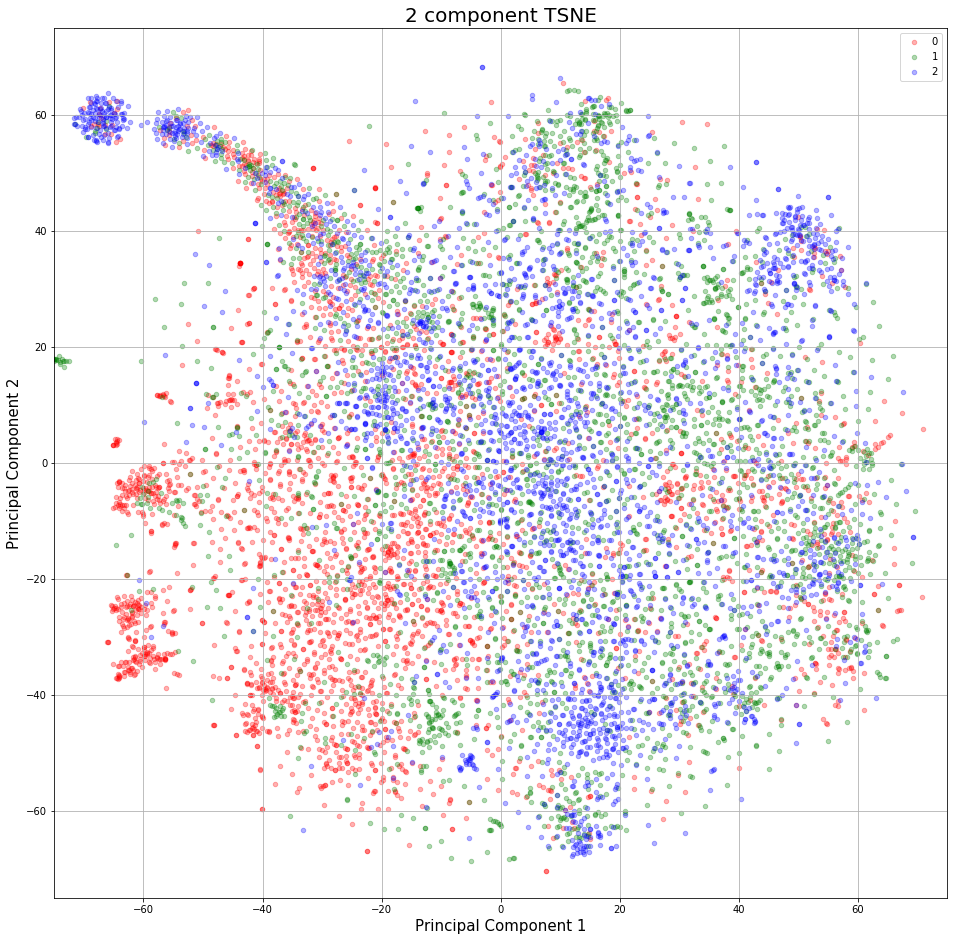

In [55]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE['class'] == target
    ax.scatter(finalDf_TSNE.loc[indicesToKeep, 'principal component 1']
               , finalDf_TSNE.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 20, alpha=0.3
              )
plt.xlim([-75, 75])
plt.ylim([-75, 75])
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='principal component 1', y='principal component 2', hue='class', data=finalDf_TSNE, s=50, palette=['red', 'green', 'blue'], alpha=0.5)

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = sns.scatterplot(x='principal component 1', y='principal component 2', hue='class', data=finalDf_TSNE, s=50, palette=['red', 'green', 'blue'], alpha=0.5)
plt.xlim([-75, 75])
plt.ylim([-75, 75])


In [ ]:
tsne = TSNE(n_components=3, learning_rate=10000)
principalComponents = tsne.fit_transform(x[:1000])
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2', 'principal component 3'])
finalDf_TSNE3d = pd.concat([principalDf, y_train], axis = 1)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE3d['class'] == target
    ax.scatter(finalDf_TSNE3d.loc[indicesToKeep, 'principal component 1'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 2'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, 
               alpha=0.3
              )
ax.legend(targets)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component TSNE', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf_TSNE3d['class'] == target
    ax.scatter(finalDf_TSNE3d.loc[indicesToKeep, 'principal component 1'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 2'],
               finalDf_TSNE3d.loc[indicesToKeep, 'principal component 3'],
               c = color,
               s = 20, 
               alpha=0.3
              )
ax.set_xlim([-400, 200])
ax.set_ylim([-200, 300])
ax.set_zlim([-400, 200])
ax.legend(targets)
ax.grid()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished


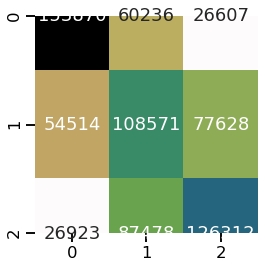

              precision    recall  f1-score   support

           0       0.65      0.64      0.65    240713
           1       0.42      0.45      0.44    240713
           2       0.55      0.52      0.54    240713

    accuracy                           0.54    722139
   macro avg       0.54      0.54      0.54    722139
weighted avg       0.54      0.54      0.54    722139



In [37]:
from sklearn.naive_bayes import GaussianNB
mnb = GaussianNB()
y_pred  = cross_val_predict(mnb, x, y_train, cv=10, verbose=1)
heatconmat(y_train, y_pred)

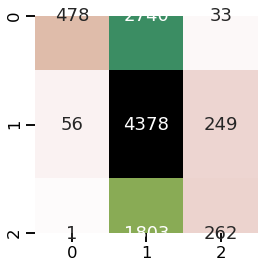

              precision    recall  f1-score   support

           0       0.89      0.15      0.25      3251
           1       0.49      0.93      0.64      4683
           2       0.48      0.13      0.20      2066

    accuracy                           0.51     10000
   macro avg       0.62      0.40      0.37     10000
weighted avg       0.62      0.51      0.42     10000



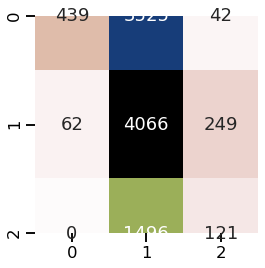

              precision    recall  f1-score   support

           0       0.88      0.11      0.19      4006
           1       0.45      0.93      0.60      4377
           2       0.29      0.07      0.12      1617

    accuracy                           0.46     10000
   macro avg       0.54      0.37      0.31     10000
weighted avg       0.59      0.46      0.36     10000



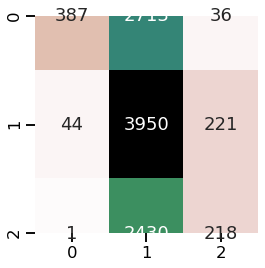

              precision    recall  f1-score   support

           0       0.90      0.12      0.22      3136
           1       0.43      0.94      0.59      4215
           2       0.46      0.08      0.14      2649

    accuracy                           0.46     10000
   macro avg       0.60      0.38      0.32     10000
weighted avg       0.59      0.46      0.36     10000



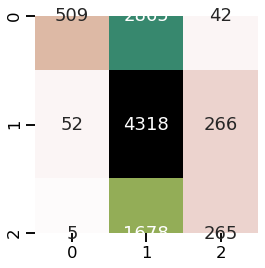

              precision    recall  f1-score   support

           0       0.90      0.15      0.26      3416
           1       0.49      0.93      0.64      4636
           2       0.46      0.14      0.21      1948

    accuracy                           0.51     10000
   macro avg       0.62      0.41      0.37     10000
weighted avg       0.62      0.51      0.42     10000



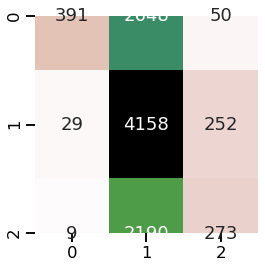

              precision    recall  f1-score   support

           0       0.91      0.13      0.22      3089
           1       0.46      0.94      0.62      4439
           2       0.47      0.11      0.18      2472

    accuracy                           0.48     10000
   macro avg       0.62      0.39      0.34     10000
weighted avg       0.60      0.48      0.39     10000



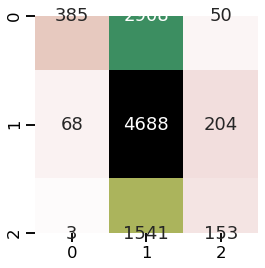

              precision    recall  f1-score   support

           0       0.84      0.12      0.20      3343
           1       0.51      0.95      0.67      4960
           2       0.38      0.09      0.15      1697

    accuracy                           0.52     10000
   macro avg       0.58      0.38      0.34     10000
weighted avg       0.60      0.52      0.42     10000



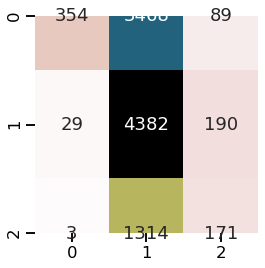

              precision    recall  f1-score   support

           0       0.92      0.09      0.16      3911
           1       0.48      0.95      0.64      4601
           2       0.38      0.11      0.18      1488

    accuracy                           0.49     10000
   macro avg       0.59      0.39      0.33     10000
weighted avg       0.64      0.49      0.38     10000



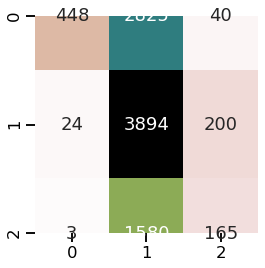

              precision    recall  f1-score   support

           0       0.94      0.14      0.24      3313
           1       0.47      0.95      0.63      4118
           2       0.41      0.09      0.15      1748

    accuracy                           0.49      9179
   macro avg       0.61      0.39      0.34      9179
weighted avg       0.63      0.49      0.40      9179



In [38]:
mnb.fit(x, y_train)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = mnb.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

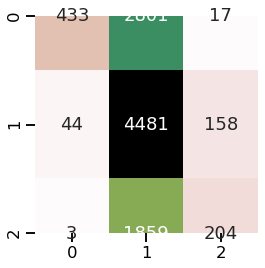

              precision    recall  f1-score   support

           0       0.90      0.13      0.23      3251
           1       0.49      0.96      0.65      4683
           2       0.54      0.10      0.17      2066

    accuracy                           0.51     10000
   macro avg       0.64      0.40      0.35     10000
weighted avg       0.63      0.51      0.41     10000



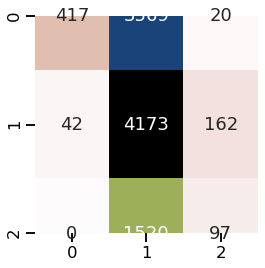

              precision    recall  f1-score   support

           0       0.91      0.10      0.19      4006
           1       0.45      0.95      0.61      4377
           2       0.35      0.06      0.10      1617

    accuracy                           0.47     10000
   macro avg       0.57      0.37      0.30     10000
weighted avg       0.62      0.47      0.36     10000



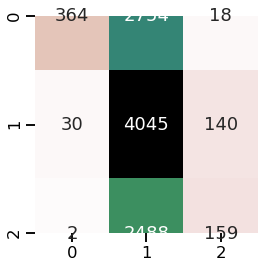

              precision    recall  f1-score   support

           0       0.92      0.12      0.21      3136
           1       0.44      0.96      0.60      4215
           2       0.50      0.06      0.11      2649

    accuracy                           0.46     10000
   macro avg       0.62      0.38      0.30     10000
weighted avg       0.60      0.46      0.35     10000



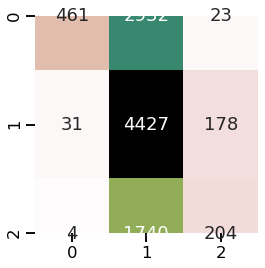

              precision    recall  f1-score   support

           0       0.93      0.13      0.24      3416
           1       0.49      0.95      0.64      4636
           2       0.50      0.10      0.17      1948

    accuracy                           0.51     10000
   macro avg       0.64      0.40      0.35     10000
weighted avg       0.64      0.51      0.41     10000



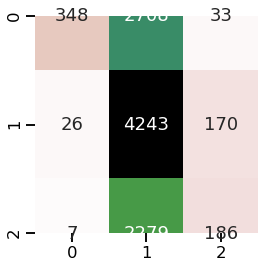

              precision    recall  f1-score   support

           0       0.91      0.11      0.20      3089
           1       0.46      0.96      0.62      4439
           2       0.48      0.08      0.13      2472

    accuracy                           0.48     10000
   macro avg       0.62      0.38      0.32     10000
weighted avg       0.60      0.48      0.37     10000



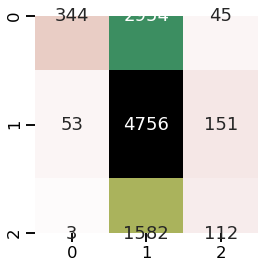

              precision    recall  f1-score   support

           0       0.86      0.10      0.18      3343
           1       0.51      0.96      0.67      4960
           2       0.36      0.07      0.11      1697

    accuracy                           0.52     10000
   macro avg       0.58      0.38      0.32     10000
weighted avg       0.60      0.52      0.41     10000



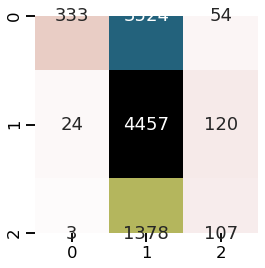

              precision    recall  f1-score   support

           0       0.93      0.09      0.16      3911
           1       0.48      0.97      0.64      4601
           2       0.38      0.07      0.12      1488

    accuracy                           0.49     10000
   macro avg       0.59      0.38      0.31     10000
weighted avg       0.64      0.49      0.37     10000



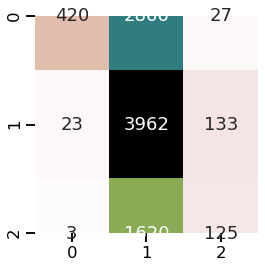

              precision    recall  f1-score   support

           0       0.94      0.13      0.22      3313
           1       0.47      0.96      0.63      4118
           2       0.44      0.07      0.12      1748

    accuracy                           0.49      9179
   macro avg       0.62      0.39      0.33      9179
weighted avg       0.63      0.49      0.39      9179



In [39]:
#y_pred  = cross_val_predict(LinearDiscriminantAnalysis(), x, y_train, cv=3)
#heatconmat(y_train, y_pred)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = fLDA.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   27.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   27.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min finished


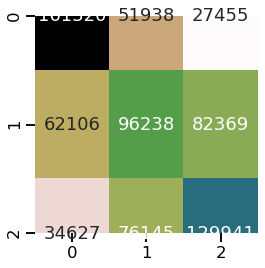

              precision    recall  f1-score   support

           0       0.63      0.67      0.65    240713
           1       0.43      0.40      0.41    240713
           2       0.54      0.54      0.54    240713

    accuracy                           0.54    722139
   macro avg       0.53      0.54      0.53    722139
weighted avg       0.53      0.54      0.53    722139



In [24]:
lrc = LogisticRegression(C=5, multi_class='multinomial', class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40, verbose=1)
y_pred  = cross_val_predict(lrc, x, y_train, cv=3, verbose=1)
heatconmat(y_train, y_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


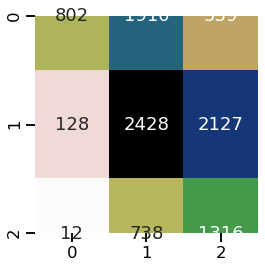

              precision    recall  f1-score   support

           0       0.85      0.25      0.38      3251
           1       0.48      0.52      0.50      4683
           2       0.33      0.64      0.44      2066

    accuracy                           0.45     10000
   macro avg       0.55      0.47      0.44     10000
weighted avg       0.57      0.45      0.45     10000



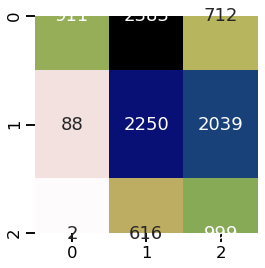

              precision    recall  f1-score   support

           0       0.91      0.23      0.36      4006
           1       0.43      0.51      0.47      4377
           2       0.27      0.62      0.37      1617

    accuracy                           0.42     10000
   macro avg       0.54      0.45      0.40     10000
weighted avg       0.60      0.42      0.41     10000



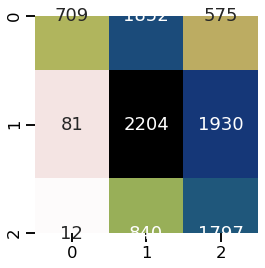

              precision    recall  f1-score   support

           0       0.88      0.23      0.36      3136
           1       0.45      0.52      0.48      4215
           2       0.42      0.68      0.52      2649

    accuracy                           0.47     10000
   macro avg       0.58      0.48      0.45     10000
weighted avg       0.58      0.47      0.45     10000



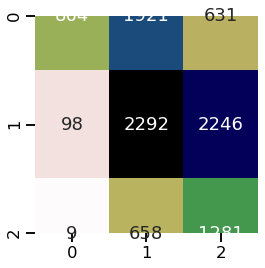

              precision    recall  f1-score   support

           0       0.89      0.25      0.39      3416
           1       0.47      0.49      0.48      4636
           2       0.31      0.66      0.42      1948

    accuracy                           0.44     10000
   macro avg       0.56      0.47      0.43     10000
weighted avg       0.58      0.44      0.44     10000



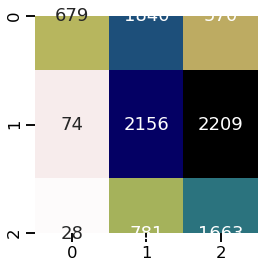

              precision    recall  f1-score   support

           0       0.87      0.22      0.35      3089
           1       0.45      0.49      0.47      4439
           2       0.37      0.67      0.48      2472

    accuracy                           0.45     10000
   macro avg       0.57      0.46      0.43     10000
weighted avg       0.56      0.45      0.44     10000



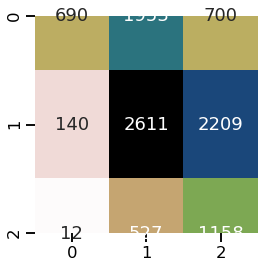

              precision    recall  f1-score   support

           0       0.82      0.21      0.33      3343
           1       0.51      0.53      0.52      4960
           2       0.28      0.68      0.40      1697

    accuracy                           0.45     10000
   macro avg       0.54      0.47      0.42     10000
weighted avg       0.58      0.45      0.44     10000



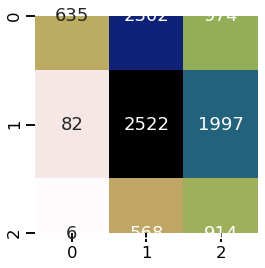

              precision    recall  f1-score   support

           0       0.88      0.16      0.27      3911
           1       0.47      0.55      0.50      4601
           2       0.24      0.61      0.34      1488

    accuracy                           0.41     10000
   macro avg       0.53      0.44      0.37     10000
weighted avg       0.59      0.41      0.39     10000



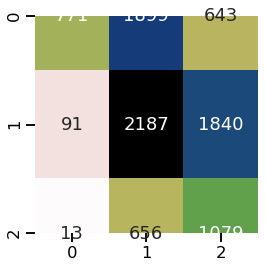

              precision    recall  f1-score   support

           0       0.88      0.23      0.37      3313
           1       0.46      0.53      0.49      4118
           2       0.30      0.62      0.41      1748

    accuracy                           0.44      9179
   macro avg       0.55      0.46      0.42      9179
weighted avg       0.58      0.44      0.43      9179



In [25]:
lrc = LogisticRegression(C=5, multi_class='multinomial', class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40, verbose=1)
lrc.fit(x, y_train)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = lrc.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Pa

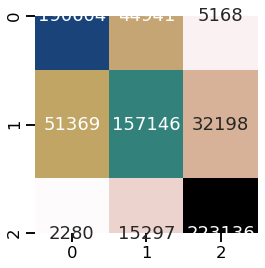

              precision    recall  f1-score   support

           0       0.78      0.79      0.79    240713
           1       0.72      0.65      0.69    240713
           2       0.86      0.93      0.89    240713

    accuracy                           0.79    722139
   macro avg       0.79      0.79      0.79    722139
weighted avg       0.79      0.79      0.79    722139



In [59]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=0, verbose=1, n_jobs=-1)
y_pred  = cross_val_predict(rfc, x, y_train, cv=3, verbose=1)
heatconmat(y_train, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


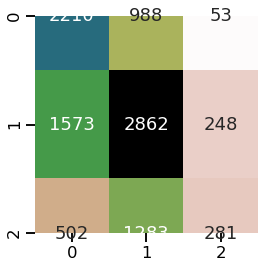

              precision    recall  f1-score   support

           0       0.52      0.68      0.59      3251
           1       0.56      0.61      0.58      4683
           2       0.48      0.14      0.21      2066

    accuracy                           0.54     10000
   macro avg       0.52      0.48      0.46     10000
weighted avg       0.53      0.54      0.51     10000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


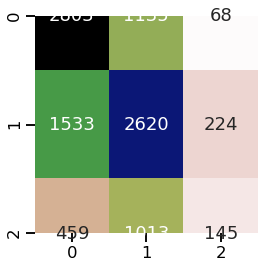

              precision    recall  f1-score   support

           0       0.58      0.70      0.64      4006
           1       0.55      0.60      0.57      4377
           2       0.33      0.09      0.14      1617

    accuracy                           0.56     10000
   macro avg       0.49      0.46      0.45     10000
weighted avg       0.53      0.56      0.53     10000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


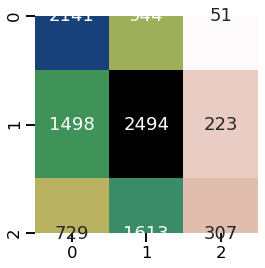

              precision    recall  f1-score   support

           0       0.49      0.68      0.57      3136
           1       0.49      0.59      0.54      4215
           2       0.53      0.12      0.19      2649

    accuracy                           0.49     10000
   macro avg       0.50      0.46      0.43     10000
weighted avg       0.50      0.49      0.46     10000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


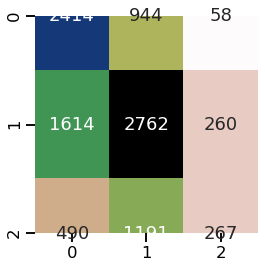

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      3416
           1       0.56      0.60      0.58      4636
           2       0.46      0.14      0.21      1948

    accuracy                           0.54     10000
   macro avg       0.52      0.48      0.47     10000
weighted avg       0.53      0.54      0.52     10000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


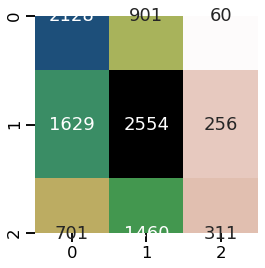

              precision    recall  f1-score   support

           0       0.48      0.69      0.56      3089
           1       0.52      0.58      0.55      4439
           2       0.50      0.13      0.20      2472

    accuracy                           0.50     10000
   macro avg       0.50      0.46      0.44     10000
weighted avg       0.50      0.50      0.47     10000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


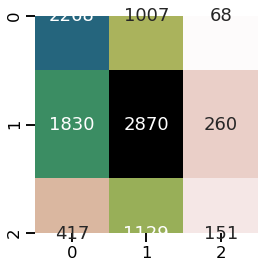

              precision    recall  f1-score   support

           0       0.50      0.68      0.58      3343
           1       0.57      0.58      0.58      4960
           2       0.32      0.09      0.14      1697

    accuracy                           0.53     10000
   macro avg       0.46      0.45      0.43     10000
weighted avg       0.51      0.53      0.50     10000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


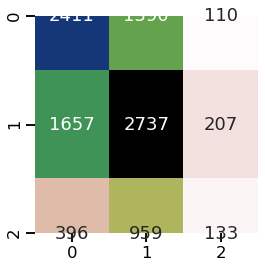

              precision    recall  f1-score   support

           0       0.54      0.62      0.58      3911
           1       0.54      0.59      0.57      4601
           2       0.30      0.09      0.14      1488

    accuracy                           0.53     10000
   macro avg       0.46      0.43      0.43     10000
weighted avg       0.50      0.53      0.51     10000



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


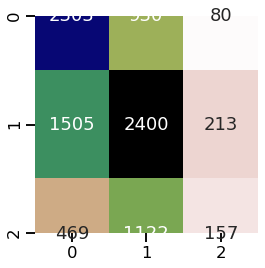

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      3313
           1       0.54      0.58      0.56      4118
           2       0.35      0.09      0.14      1748

    accuracy                           0.53      9179
   macro avg       0.48      0.46      0.44      9179
weighted avg       0.50      0.53      0.50      9179



In [60]:
rfc.fit(x, y_train)
y_preds = [[] for _ in range(len(X_valids))]
for i in range(len(X_valids)):
    y_preds[i] = rfc.predict(X_valids[i])
    heatconmat(y_valids[i], y_preds[i])

In [61]:
def heatconmat(y_true, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_train.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
gm = BayesianGaussianMixture(3)
gm.fit(X_train, y_train)
y_pred = gm.predict(X_train)
heatconmat(y_train, y_pred)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
#svc=SVC(probability=True, kernel='linear')
clf = RandomForestClassifier(n_estimators=100, random_state=0)
ada = AdaBoostClassifier(base_estimator=clf, algorithm='SAMME.R')
#y_pred = cross_val_predict(ada, x, y_train, cv=10)
#heatconmat(y_train, y_pred)

In [ ]:
ada.fit(X_train, y_train)
y_pred = ada.predict(X_train)
heatconmat(y_train, y_pred)

In [ ]:
from sklearn.ensemble import BaggingClassifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
bag = BaggingClassifier(base_estimator=clf)
y_pred = cross_val_predict(bag, x, y_train, cv=10)
heatconmat(y_train, y_pred)

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(3)
bgm.fit(x, y_train)  
y_pred = cross_val_predict(bgm, x, y_train, cv=10)
heatconmat(y_train, y_pred)
y_preds = [bgm.predict()]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
analyzer, min_df, ... = get_args()    
# to be implemented # a number of options can control a vectorizer, I reckon you investigate them  
vectorizer = TfidfVectorizer(analyzer=analyzer, min_df=min_df,                                                    
                             max_df=max_df, max_features=max_features,                                                    
                             ngram_range=(ngram_inf,ngram_sup),                                                    
                             stop_words='english') 
df = pd.read_csv(sys.stdin, names=['blog', 'class'])
X_train = vectorizer.fit_transform(df[blog])                                      
# isn’t life beautiful ? # several meta-parameters can influence the performance of Logit (investigate) 
clf = LogisticRegression(C=5,class_weight='balanced', solver='newton-cg',                                              
                         multi_class='multinomial', n_jobs=-1, random_state=40, verbose=1) 
clf.fit(X_train, df[classe])              

In [62]:
from sklearn.svm import SVC
svc=SVC(probability=True, kernel='linear')
#y_pred = cross_val_predict(svc, x, y_train, cv=3, verbose=1)
#heatconmat(y_train, y_pred)